# get stimuli timestamp

In [31]:
# This example imports functions from the DemoReadSGLXData module to read
# analog data and convert it to volts based on the metadata information.
# The metadata file must be present in the same directory as the binary file.
# Works with both imec and nidq analog channels.
import numpy as np
import matplotlib.pyplot as plt
from toolbox_ap_process import filter_signal
from toolbox_load_data import load_ephyData, load_ttlData

In [32]:
ap_path = 'Z:/data/0_collaboration/ceph_phys/GLC5843/ceph_5843_1_g0/ceph_5843_1_g0_imec0/ceph_5843_1_g0_t0.imec0.ap.bin'
ttl_path = 'Z:/data/0_collaboration/ceph_phys/GLC5843/ceph_5843_1_g0/ceph_5843_1_g0_t0.nidq.bin'
ttl_chan = 1

In [33]:
ttl_data, sRate_ttl, meta_ttl = load_ttlData(ttl_path,ttl_chan)

nChan: 9, nFileSamp: 167160864


In [34]:
stimuli_duration = 1

In [35]:
start_idx = np.min(np.where(ttl_data>20000)[0])-int(sRate_ttl)
foi = ttl_data[start_idx:int(start_idx+520*sRate_ttl)] # a rough frame that contains all grating patch
foi = np.where(foi>20000,30000,0)# ugly way to denoise the frame
stimuli_ontid = np.where(np.diff(foi)==30000)[0][12:]+1+start_idx
stimuli_offtid = stimuli_ontid+sRate_ttl*stimuli_duration

T_before_onset = 5
T_after_offset = 5

tStart =  stimuli_ontid[0]/sRate_ttl - T_before_onset
tEnd = stimuli_offtid[-1]/sRate_ttl + T_after_offset

ttl_target_stim = foi[int(tStart*int(sRate_ttl) - start_idx):int(tEnd*int(sRate_ttl) - start_idx)]

tID_stim_on = (stimuli_ontid - stimuli_ontid[0] + int(sRate_ttl)*T_before_onset).astype(int)
tID_stim_off = (stimuli_offtid - stimuli_ontid[0] + int(sRate_ttl)*T_before_onset).astype(int)

tStimOnset = tID_stim_on/int(sRate_ttl)
tStimOffset = tID_stim_off/int(sRate_ttl)

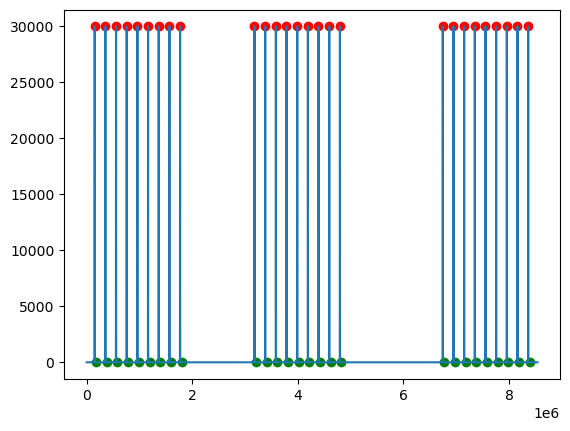

In [6]:
## crop the stimuli frame: we only care about what happened (1s before onset~1s after all stimuli delivered)  
plt.plot(ttl_target_stim)
plt.scatter(tID_stim_on, ttl_target_stim[tID_stim_on],color='red')
plt.scatter(tID_stim_off, ttl_target_stim[tID_stim_off],color='green')

In [7]:
plt.close('all')

# load raw data (neuropixel)

In [36]:
# Other parameters about what data to read
## only use the frame we plotted
chanList = np.arange(80,120)    # list of channels to extract, by index in saved file

In [37]:

selectData_ap,sRate_ap,meta_ap = load_ephyData(ap_path, tStart, tEnd, chanList)


nChan: 385, nFileSamp: 167146363


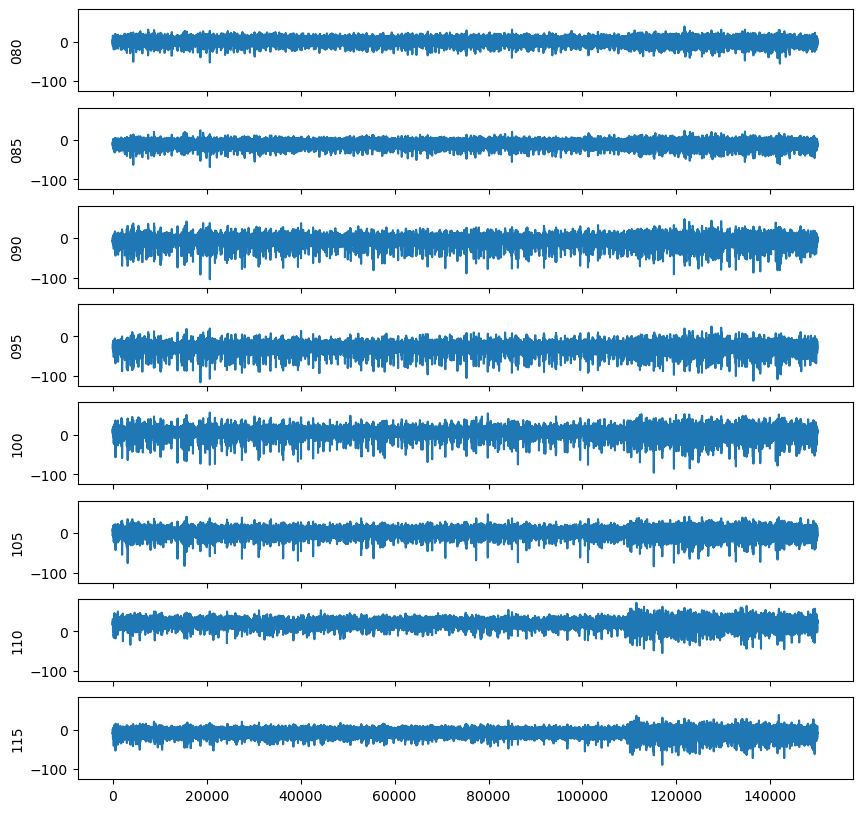

In [14]:
sample_interval = 5
fig, axes = plt.subplots(nrows=int(len(selectData_ap)/sample_interval),ncols=1,sharex=True, sharey=True, figsize = (10,10))
for i,chanid in enumerate(np.arange(0,len(selectData_ap),sample_interval)):
    axes[i].plot(selectData_ap[chanid][int(15*sRate_ap):int(20*sRate_ap)])
    axes[i].set_ylabel('%03d'%(chanid+80))
    # axes[i].set_xticks(np.arange(0,5,5)*sRate,np.arange(0,25,5))
# plt.savefig('rawData_timeframe_lfp.png')

In [38]:
print('start time %.2f s'%tStart)

start time 3811.26 s


# preprocess data 
## Step1: filter signal

In [39]:
xf = filter_signal(selectData_ap, sRate_ap, 500, 4000)

In [15]:
#np.save('filteredData_grating_patch.npy',xf)

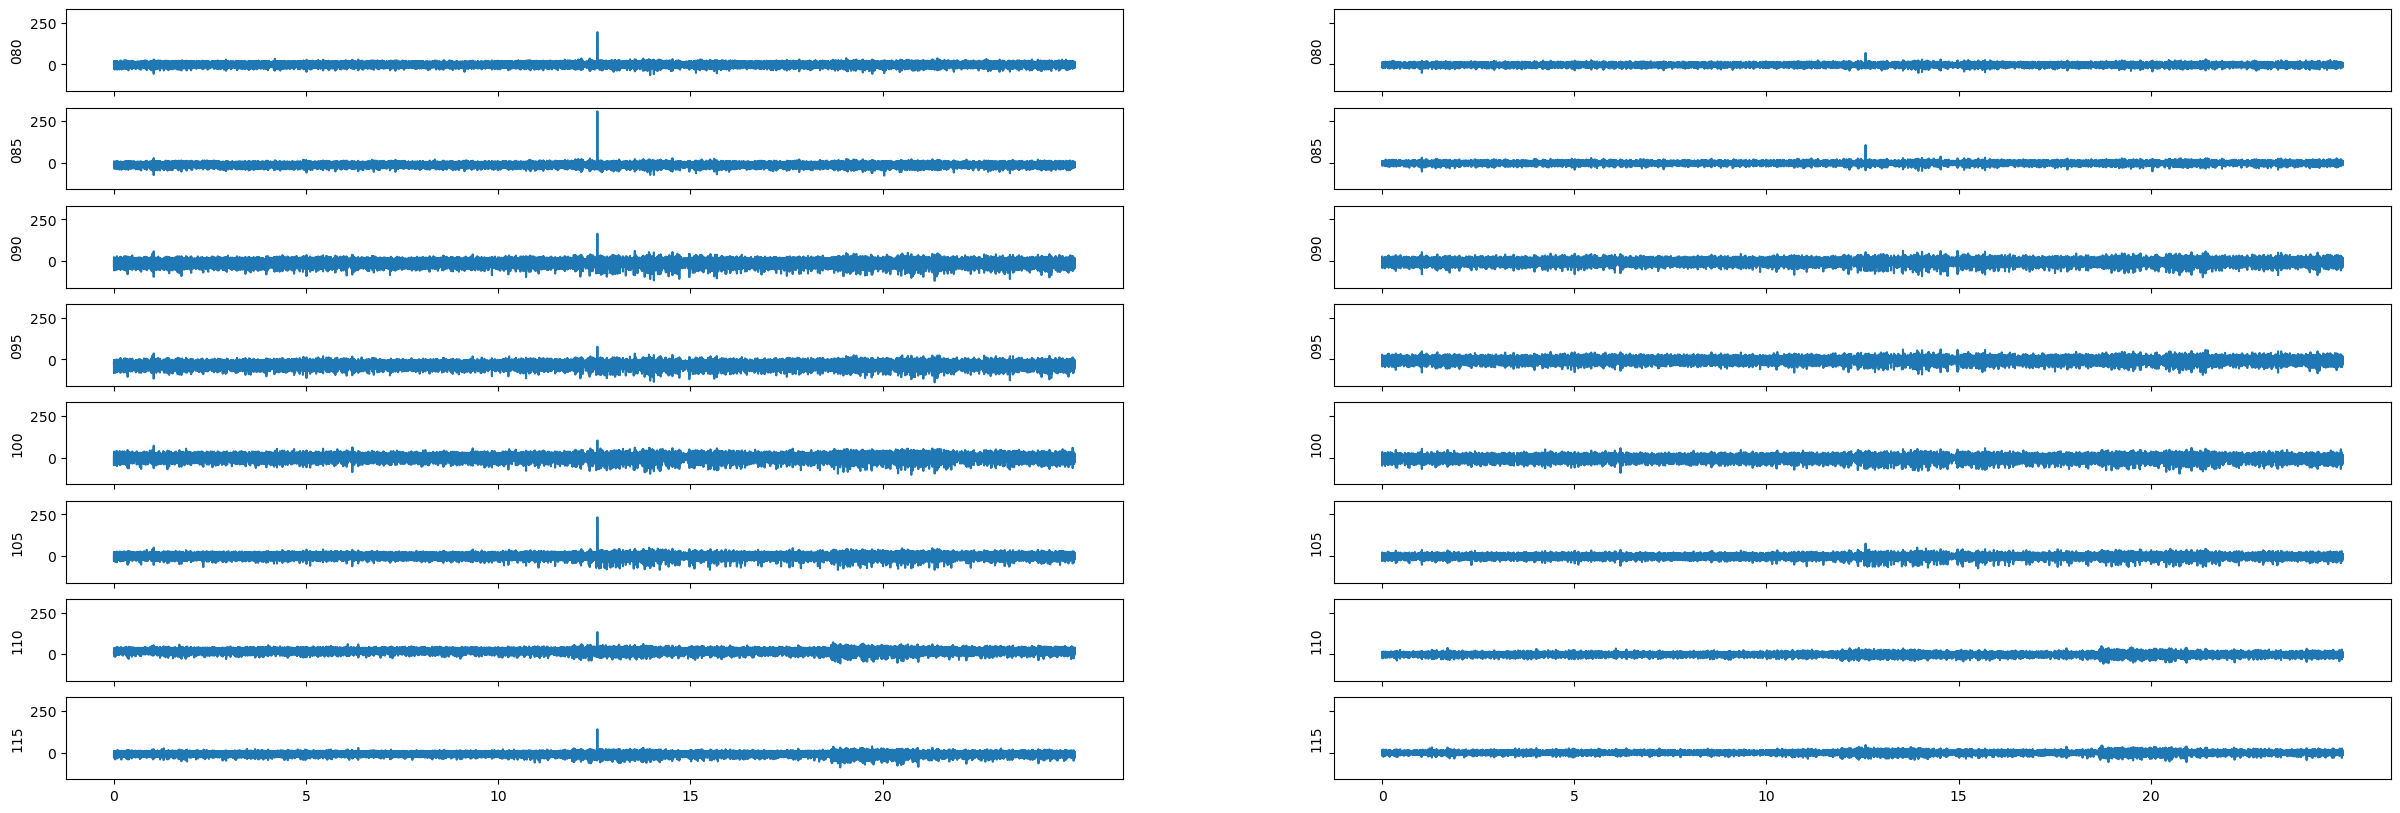

In [11]:
sample_interval = 5
fig, axes = plt.subplots(nrows=int(len(xf)/sample_interval),ncols=2,figsize = (30,10),sharex=True,sharey=True)
for i,chanid in enumerate(np.arange(0,len(xf),sample_interval)):
    axes[i,0].plot(selectData_ap[chanid][:int(25*sRate_ap)])
    axes[i,0].set_ylabel('%03d'%(chanid+chanList[0]))
    axes[i,0].set_xticks(np.arange(0,25,5)*sRate_ap,np.arange(0,25,5))
    axes[i,1].plot(xf[chanid][:int(25*sRate_ap)])
    axes[i,1].set_ylabel('%03d'%(chanid+chanList[0]))
    axes[i,1].set_xticks(np.arange(0,25,5)*sRate_ap,np.arange(0,25,5))
#plt.savefig('filtered_Data_timeframe_uV.png')

## Step2: detect AP

In [162]:
from toolbox_ap_process import detect_spikes

In [163]:
# xf = np.load('filteredData_grating_patch.npy',allow_pickle=True)

In [164]:
(s, t), threshold, s_all, nSpk = detect_spikes(xf, sRate_ap, N=4,lockout=1)
print('from chan %03d to %03d: found %d spikes with th %.2f'%(chanList[0],chanList[-1],len(s_all),threshold))

from chan 080 to 119: found 588508 spikes with th -18.64


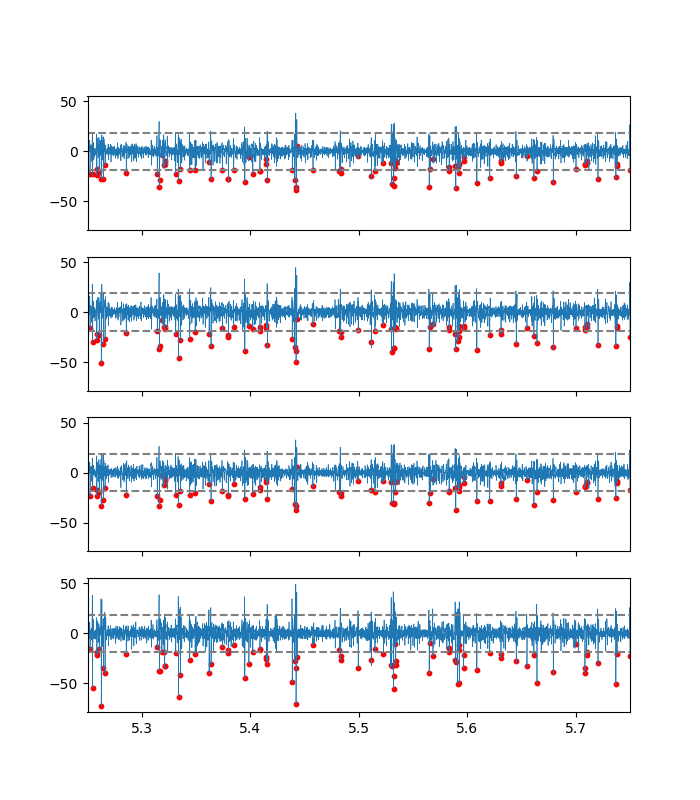

In [224]:
fig, axes = plt.subplots(nrows=4,ncols=1,sharey = True, sharex=True, figsize = (7,8))
start_time = 5.25
stop_time = 5.75
time_series = np.arange(start_time, stop_time, step=1/sRate_ap)
%matplotlib widget
from ipywidgets import interact
(s_sample, t_sample), threshold_sample, s_all_sample, s_counts = detect_spikes(xf[11:15], sRate_ap, N=4, lockout=1)
peak_times = t_sample[np.where((t_sample<(stop_time*1000))&(t_sample>(start_time*1000)))[0]]/1000
for i,chanid in enumerate(np.arange(11,15)):
    axes[i] = plot_peaks(axes[i], time_series,  xf[chanid], sRate_ap, peak_times, threshold)

#plt.savefig('detected_spks_Data_timeframe_uV.png')

In [227]:
%matplotlib inline
plt.close('all')

# normalize data 

In [231]:
%matplotlib inline

from toolbox_ap_process import get_spkTrain

ImportError: cannot import name 'get_spkTrain' from 'toolbox_ap_process' (C:\Users\su-xiongy\Documents\realtime-analysis\toolbox_ap_process.py)

In [ ]:
spike_counts, bin_size = get_spkTrain(t)

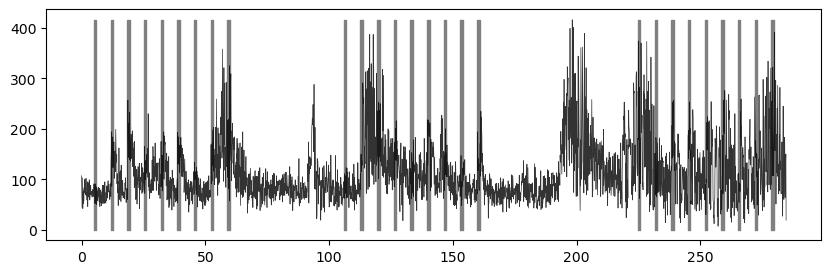

In [232]:
time_series = np.linspace(0,tEnd-tStart,len(spike_counts))
tStimOnset = tStimOnset.flatten()
tStimOffset = tStimOffset.flatten()

plt.figure(figsize=(10,3))
for i in range(len(tStimOnset)):
    plt.fill_betweenx([0,np.max(spike_counts)], tStimOnset[i], tStimOffset[i], color="grey", alpha=1)
plt.plot(time_series, spike_counts,color='black',linewidth=.5,alpha=.8)



In [255]:
stimuli_duration = 1

In [256]:
nSpk_ONset=np.zeros((len(tStimOnset),int(1000*stimuli_duration/bin_size)))
nSpk_OFFset=np.zeros((len(tStimOnset),int(1000*stimuli_duration/bin_size)))

for i in range(len(tStimOnset)):
    nSpk_ONset[i] = spike_counts[int(tStimOnset[i]*1000*stimuli_duration/bin_size):int(tStimOffset[i]*1000*stimuli_duration/bin_size)]
    nSpk_OFFset[i] = spike_counts[int((tStimOnset[i]-1)*1000*stimuli_duration/bin_size):int(tStimOnset[i]*1000*stimuli_duration/bin_size)]
    
    

In [234]:
nSpk_ONset_pos = nSpk_ONset.reshape(3,9,int(1000/bin_size))
nSpk_OFFset_pos = nSpk_OFFset.reshape(3,9,int(1000/bin_size))

In [266]:
nSpk_ONset_pos_500ms = nSpk_ONset_pos[:,:,int(500*stimuli_duration/bin_size):].mean(axis=2)/nSpk_ONset_pos[:,:,int(500*stimuli_duration/bin_size):].std(axis=2)
nSpk_OFFset_pos_500ms = nSpk_OFFset_pos[:,:,int(500*stimuli_duration/bin_size):].mean(axis=2)/nSpk_OFFset_pos[:,:,int(500*stimuli_duration/bin_size):].std(axis=2)
diff_Spk = nSpk_ONset_pos_500ms - nSpk_OFFset_pos_500ms
normalized_Spk = np.mean(diff_Spk,axis=0)


In [ ]:
diff_Spk = (nSpk_ONset_pos - nSpk_OFFset_pos).mean(axis=2)


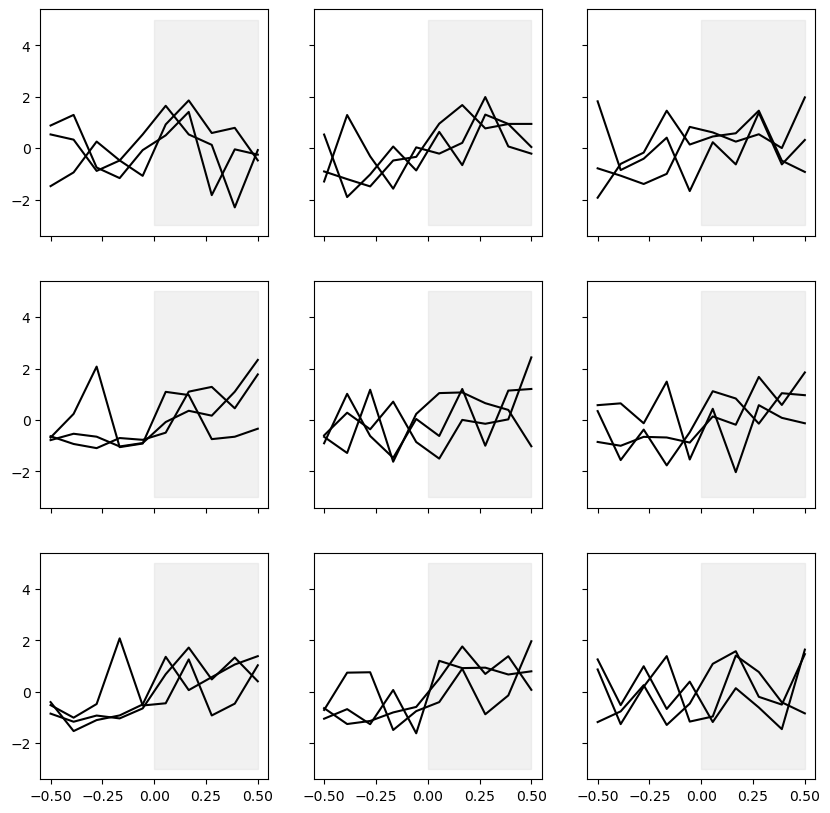

In [254]:

time_series = np.tile(np.linspace(-.5,.5,int(1000/bin_size)),nSpk_OFFset_pos.shape[0]).reshape((nSpk_OFFset_pos.shape[0],int(1000/bin_size)))
fig, axes = plt.subplots(nrows=3,ncols=3,sharey = True, sharex=True, figsize = (10,10))
for i in range(9):    
    d = np.concatenate([nSpk_OFFset_pos[:,i,-int(500/bin_size):].T,nSpk_ONset_pos[:,i,-int(500/bin_size):].T],axis=0)
    d = (d - d.mean(axis=0))/d.std(axis=0)
    row, col = i%3,i//3
    axes[row,col].plot(time_series.T,d,c='black')
    axes[row,col].fill_betweenx([-3,5],0,np.max(time_series),color="lightgrey", alpha=.3)
    

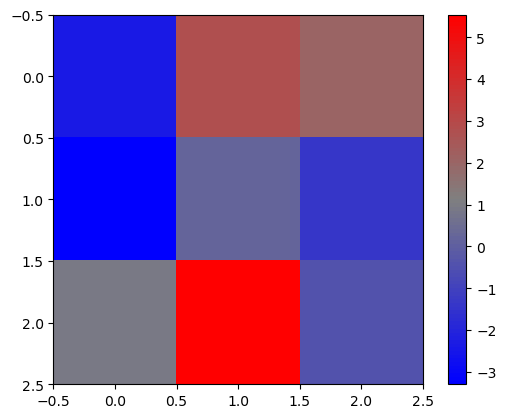

In [267]:
plt.figure()
plt.imshow(normalized_Spk.reshape(3,3).T,cmap=cm) # tranpose because we first go through one column then second col 
plt.colorbar()
%matplotlib inline

In [15]:
def plot_multiple_rawdata(axs, time_axis, data_arr, average_data, fs, linecolor, offset=30):
    yoffset_mat = offset * np.arange(1,len(data_arr)+1)[:,np.newaxis] * np.ones((data_arr.shape[0],len(time_series)))
    data_arr = data_arr + yoffset_mat
    time_axis_new = np.tile(time_axis,data_arr.shape[0]).reshape(data_arr.shape[0], len(time_axis))
    data_arr[:,0:5] = np.nan
    time_axis_new[:,0:5] = np.nan
    axs.plot(time_axis_new.T, data_arr.T, linewidth=.2, c='black')
    axs.axvline(x=0,linestyle='--',c='lightgrey')
    axs.fill_betweenx([np.min(average_data),np.nanmax(data_arr)],0,np.max(time_axis),color="lightgrey", alpha=.3)
    axs.plot(time_axis, average_data, linewidth=.2, c=linecolor)
    
    # Remove x and y ticks
    axs.set_xticks([])
    axs.set_yticks([])

    # Optional: Remove spines
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    
    return axs, data_arr


In [16]:
def find_middle_channels(a, b, num_channels):
    # Calculate the midpoint of the range
    midpoint = (a + b) / 2
    
    # Adjust the start index based on the number of channels requested
    if num_channels % 2 == 0:
        # Even number of channels
        start_channel = int(midpoint - (num_channels / 2)) + 1
    else:
        # Odd number of channels, skew towards the higher side
        start_channel = int(midpoint - (num_channels / 2))
    
    # Generate the channels
    channels = [start_channel + i for i in range(num_channels)]
    
    return channels

In [23]:
np.linspace(np.arange(3),np.arange(1,4),10).shape

(10, 3)

In [20]:
test = np.arange(24).reshape(4,6)

In [22]:
test[:,np.array([[1,2,3],[2,3,4]])].shape

(4, 2, 3)

In [44]:
def prepare_rawData_condition(x, onset_time, offset_time, fs):
    
    time_series = np.linspace(onset_time, offset_time, 
                              int((offset_time-onset_time).mean()*fs), endpoint=True).T # Nsession*Ntimepoint
    time_index = (time_series*fs).astype(int) 
    return x[:,time_index] # Nchannel*Nsession*Ntimepoint
    

In [43]:
start_time_stim

array([ 45.92979035, 146.8489651 , 265.71467853])

In [49]:
i = 6


array([22, 18], dtype=int64)

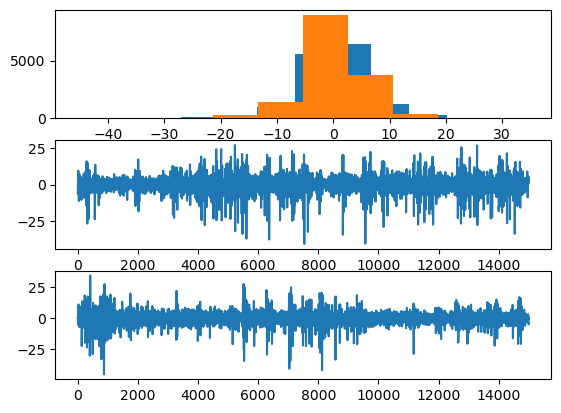

In [59]:
fig, axes = plt.subplots(nrows=3,ncols=1)
coi = 8
soi = 1
axes[0].hist(vol_data_stim[coi,soi,:])
axes[0].hist(vol_data_base[coi,soi,:])
axes[1].plot(vol_data_stim[coi,soi,:])
axes[2].plot(vol_data_base[coi,soi,:])

In [ ]:
#coi = np.argsort(nSpk)[-2:]
tStimOnset_cond = tStimOnset.reshape((3,9))
tStimOffset_cond = tStimOffset.reshape((3,9))
stim_duration = .5
time_axis = np.arange(-stim_duration,stim_duration,step=1/sRate_ap)


fig, axes = plt.subplots(nrows=3,ncols=3,sharey = True, sharex=True, figsize = (10,10))
for i in range(tStimOnset_cond.shape[1]):
    start_time_stim = tStimOnset_cond[:,i] + stim_duration
    stop_time_stim = tStimOffset_cond[:,i]
    vol_data_stim = prepare_rawData_condition(x, start_time_stim, stop_time_stim, sRate_ap)
    
    stim_duration = .5
    tStimOnset_cond = tStimOnset.reshape((3,9))
    tStimOffset_cond = tStimOffset.reshape((3,9))
    start_time_stim = tStimOnset_cond[:,i] + stim_duration
    stop_time_stim = tStimOffset_cond[:,i]
    vol_data_stim = prepare_rawData_condition(xf, start_time_stim, stop_time_stim, sRate_ap)

    start_time_base = tStimOnset_cond[:,i] - stim_duration
    stop_time_base = tStimOnset_cond[:,i]
    vol_data_base = prepare_rawData_condition(xf, start_time_base, stop_time_base, sRate_ap) 

    coi = np.argsort((vol_data_stim.std(axis=2) - vol_data_base.std(axis=2)).mean(axis=1))[-2:]
    
    stop_time = tStimOnset_cond[:,i] + stim_duration

    
    vol_data = np.zeros((tStimOnset_cond[:,i].shape[0], len(coi), time_axis.shape[0]))
    avg_data = np.zeros((tStimOnset_cond[:,i].shape[0], time_axis.shape[0]))
    for j in range(tStimOnset_cond[:,i].shape[0]):
        time_series = np.linspace(tStimOnset_cond[j,i]-stim_duration, tStimOnset_cond[j,i]+stim_duration, int(2*stim_duration*sRate_ap), endpoint=True)
        time_index = (time_series*sRate_ap).astype(int)
        vol_data[j,] = xf[coi][:,time_index]
        avg_data[j,] = xf[:,time_index].mean(axis=0)
    row, col = i%3,i//3
    vol_data = vol_data.reshape(tStimOnset_cond[:,i].shape[0]*len(coi),len(time_axis))
    avg_data = avg_data.mean(axis=0)
    axes[row,col],data_arr = plot_multiple_rawdata(axes[row,col], time_axis, vol_data, avg_data, sRate_ap, colors[i],60)
    
    

In [17]:
#coi = np.argsort(nSpk)[-2:]
tStimOnset_cond = tStimOnset.reshape((3,9))
tStimOffset_cond = tStimOffset.reshape((3,9))
stim_duration = 1
time_axis = np.arange(-stim_duration,stim_duration,step=1/sRate_ap)
fig, axes = plt.subplots(nrows=3,ncols=3,sharey = True, sharex=True, figsize = (10,10))
for i in range(tStimOnset_cond.shape[1]):
    start_time = tStimOnset_cond[:,i] - stim_duration
    stop_time = tStimOnset_cond[:,i] + stim_duration
    vol_data = np.zeros((tStimOnset_cond[:,i].shape[0], len(coi), time_axis.shape[0]))
    avg_data = np.zeros((tStimOnset_cond[:,i].shape[0], time_axis.shape[0]))
    for j in range(tStimOnset_cond[:,i].shape[0]):
        time_series = np.linspace(tStimOnset_cond[j,i]-stim_duration, tStimOnset_cond[j,i]+stim_duration, int(2*stim_duration*sRate_ap), endpoint=True)
        time_index = (time_series*sRate_ap).astype(int)
        vol_data[j,] = xf[coi][:,time_index]
        avg_data[j,] = xf[:,time_index].mean(axis=0)
    row, col = i%3,i//3
    vol_data = vol_data.reshape(tStimOnset_cond[:,i].shape[0]*len(coi),len(time_axis))
    avg_data = avg_data.mean(axis=0)
    axes[row,col],data_arr = plot_multiple_rawdata(axes[row,col], time_axis, vol_data, avg_data, sRate_ap, colors[i],60)
    
    

NameError: name 'nSpk' is not defined

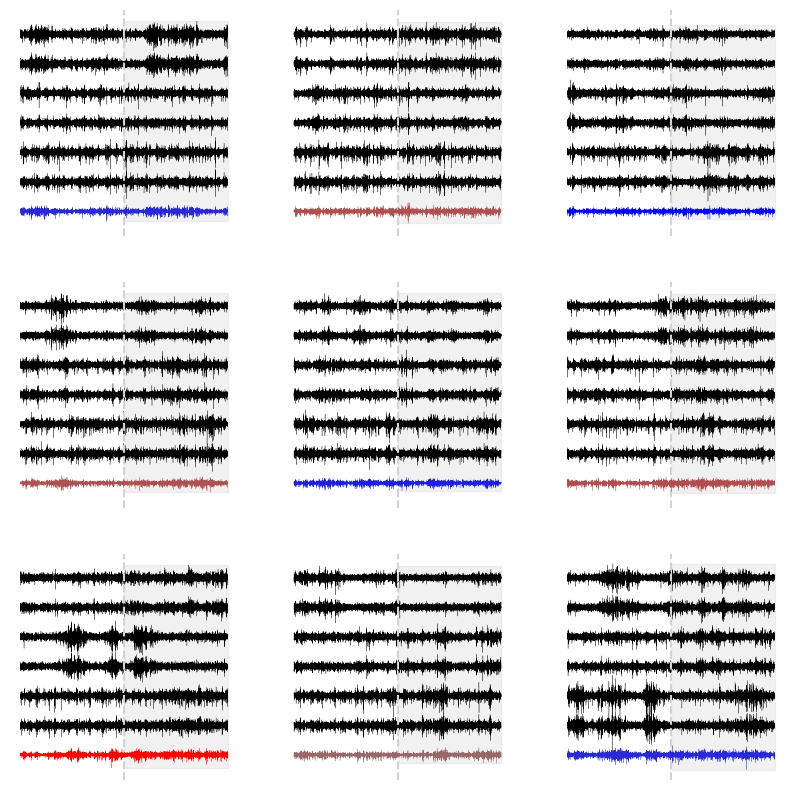

In [214]:
coi = np.argsort(nSpk)[-2:]
tStimOnset_cond = tStimOnset.reshape((3,9))
tStimOffset_cond = tStimOffset.reshape((3,9))
stim_duration = .5
time_axis = np.arange(-stim_duration,stim_duration,step=1/sRate_ap)
fig, axes = plt.subplots(nrows=3,ncols=3,sharey = True, sharex=True, figsize = (10,10))
for i in range(tStimOnset_cond.shape[1]):
    start_time = tStimOnset_cond[:,i] - stim_duration
    stop_time = tStimOnset_cond[:,i] + stim_duration
    vol_data = np.zeros((tStimOnset_cond[:,i].shape[0], len(coi), time_axis.shape[0]))
    avg_data = np.zeros((tStimOnset_cond[:,i].shape[0], time_axis.shape[0]))
    for j in range(tStimOnset_cond[:,i].shape[0]):
        time_series = np.linspace(tStimOnset_cond[j,i]-stim_duration, tStimOnset_cond[j,i]+stim_duration, int(2*stim_duration*sRate_ap), endpoint=True)
        time_index = (time_series*sRate_ap).astype(int)
        vol_data[j,] = xf[coi][:,time_index]
        avg_data[j,] = xf[:,time_index].mean(axis=0)
    row, col = i%3,i//3
    vol_data = vol_data.reshape(tStimOnset_cond[:,i].shape[0]*len(coi),len(time_axis))
    avg_data = avg_data.mean(axis=0)
    axes[row,col],data_arr = plot_voltage_with_position(axes[row,col], time_axis, vol_data, avg_data, sRate_ap, colors[i],60)
    
    

In [ ]:
coi = np.argsort(nSpk)[-2:]
tStimOnset_cond = tStimOnset.reshape((3,9))
tStimOffset_cond = tStimOffset.reshape((3,9))
stim_duration = .5
time_axis = np.arange(-stim_duration,stim_duration,step=1/sRate_ap)
fig, axes = plt.subplots(nrows=3,ncols=3,sharey = True, sharex=True, figsize = (10,10))
for i in range(tStimOnset_cond.shape[1]):
    start_time = tStimOnset_cond[:,i] - stim_duration
    stop_time = tStimOnset_cond[:,i] + stim_duration
    vol_data = np.zeros((tStimOnset_cond[:,i].shape[0], len(coi), time_axis.shape[0]))
    avg_data = np.zeros((tStimOnset_cond[:,i].shape[0], time_axis.shape[0]))
    for j in range(tStimOnset_cond[:,i].shape[0]):
        time_series = np.linspace(tStimOnset_cond[j,i]-stim_duration, tStimOnset_cond[j,i]+stim_duration, int(2*stim_duration*sRate_ap), endpoint=True)
        time_index = (time_series*sRate_ap).astype(int)
        vol_data[j,] = xf[coi][:,time_index]
        avg_data[j,] = xf[:,time_index].mean(axis=0)
    row, col = i%3,i//3
    vol_data = vol_data.reshape(tStimOnset_cond[:,i].shape[0]*len(coi),len(time_axis))
    avg_data = avg_data.mean(axis=0)
    axes[row,col],data_arr = plot_voltage_with_position(axes[row,col], time_axis, vol_data, avg_data, sRate_ap, colors[i],60)
    
    